In [1]:
#load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import shap

In [2]:
# load data for preprocessed data
df = pd.read_csv('../data/interim/redfin_data_to_model.csv', index_col=0)
df.head()

,zipcode,price,beds,baths,square_feet,lot_size,year_built,days_on_market,hoa_per_mon,latitude,longitude,propertytype_singlefamily,city_Henderson,city_BlueDiamond,city_BoulderCity,city_NorthLasVegas,city_Enterprise
0,89117,621500,4.0,2.50,2352.0,6098.0,1994.0,19.0,146.0,36.154483,-115.297871,1,0,0,0,0,0
1,89117,400000,4.0,3.00,1883.0,3920.0,1995.0,44.0,67.0,36.128126,-115.263408,1,0,0,0,0,0
2,89117,339000,4.0,2.50,2230.0,4356.0,1995.0,44.0,67.0,36.127931,-115.263037,1,0,0,0,0,0
3,89117,818000,4.0,5.00,4863.0,20038.0,1993.0,44.0,67.0,36.151716,-115.268710,1,0,0,0,0,0
4,89145,335000,3.0,2.75,1613.0,2614.0,2001.0,39.0,175.0,36.160917,-115.294868,0,0,0,0,0,0


In [3]:
df.shape

(11547, 17)

In [4]:
# isolating dependent variable from features
y = df['price']
X = df.drop(columns=['price'])

X.shape, y.shape

((11547, 16), (11547,))

After testing my model with and without using vif, I've decided not to use it because my model performed much better without.

In [5]:
'''
def iterate_vif(X, vif_threshold=11, max_vif=12):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["features"] = X.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            X = X.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            break
    return X, vif.sort_values('VIFactor')

final_X, final_vif = iterate_vif(X)
'''

'\ndef iterate_vif(X, vif_threshold=11, max_vif=12):\n    count = 0\n    while max_vif > vif_threshold:\n        count += 1\n        print("Iteration # "+str(count))\n        vif = pd.DataFrame()\n        vif["VIFactor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]\n        vif["features"] = X.columns\n\n        if vif[\'VIFactor\'].max() > vif_threshold:\n            print(\'Removing %s with VIF of %f\' % (vif[vif[\'VIFactor\'] == vif[\'VIFactor\'].max()][\'features\'].values[0], vif[\'VIFactor\'].max()))\n            X = X.drop(vif[vif[\'VIFactor\'] == vif[\'VIFactor\'].max()][\'features\'].values[0], axis=1)\n            max_vif = vif[\'VIFactor\'].max()\n        else:\n            print(\'Complete\')\n            break\n    return X, vif.sort_values(\'VIFactor\')\n\nfinal_X, final_vif = iterate_vif(X)\n'

In [6]:
#final_X.head()

In [7]:
#final_vif

In [8]:
#X = final_X

## Splitting data into train/test sets

In [9]:
# splitting data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Evaluating R^2 score for different regression models

##### LinearRegression()

In [10]:
lr_model = LinearRegression().fit(X_train, y_train)
lr_model.score(X_train, y_train)

0.735479403180193

In [11]:
lr_model.score(X_test, y_test)

0.7477430525629187

##### RandomForestRegressor()

In [12]:
rfr_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
rfr_model.score(X_train, y_train)

0.9792846564404013

In [13]:
rfr_model.score(X_test, y_test)

0.8750237556978063

##### GradientBoostingRegressor()

In [14]:
gbr_model = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
gbr_model.score(X_train, y_train)

0.9318526537916674

In [15]:
gbr_model.score(X_test, y_test)

0.8628651533998674

##### AdaBoostRegressor()

In [16]:
abr_model = AdaBoostRegressor(random_state=42).fit(X_train, y_train)
abr_model.score(X_train, y_train)

0.48283897078218085

In [17]:
abr_model.score(X_test, y_test)

0.46386188563344266

##### XGBRegressor()

In [18]:
xgbr_model = XGBRegressor().fit(X_train, y_train)
xgbr_model.score(X_train, y_train)

0.9912564672142605

In [19]:
xgbr_model.score(X_test, y_test)

0.8729418068803841

### Results

While the XGBRegressor appears to perform the best on the training data, RandomForestRegressor consistantly outperforms the XGBRegressor on the test set. I would like to see how both of these perform with GridSearchCV since the scores are so close.  

## Hyperparameter tuning for RandomForestRegressor model using GridSearchCV

In [20]:
# setting param_grid variable for RandomForestRegressor GridSearchCV
param_grid_rfr = {
    'max_depth': range(3,15),
    'n_estimators': (10, 50, 100, 1000),
    'max_features': ('auto', 'sqrt', 'log2')
    }

# GridSearchCV for RandomForestRegressor model
rfr_cv = GridSearchCV(
    estimator=RandomForestRegressor(), 
    param_grid=param_grid_rfr, 
    cv=5, n_jobs=-1)

rfr_cv.fit(X_train, y_train)

print("Random Forest Best Score: " + str(rfr_cv.best_score_))
print("Random Forest Best Parameters: " + str(rfr_cv.best_params_))

Random Forest Best Score: 0.8612142173119061
Random Forest Best Parameters: {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 50}


In [21]:
best_params_rfr = rfr_cv.best_params_

## Hyperparameter tuning for XGBRegressor model using GridSearchCV

In [22]:
# setting param_grid variable for GXGBoostRegressor GridSearchCV
param_grid_xgbr = {
    'max_depth': range(3,15),
    'eta': (0.3, 0.2, 0.1, 0.01, 0.005)
        }

xgbr_cv = GridSearchCV(
    estimator=XGBRegressor(), 
    param_grid=param_grid_xgbr,
    cv=5, n_jobs=-1)

xgbr_cv.fit(X_train, y_train)

print("XGBoost Best Score: " + str(xgbr_cv.best_score_))
print("XGBoost Best Parameters: " + str(xgbr_cv.best_params_))

XGBoost Best Score: 0.8660038841972069
XGBoost Best Parameters: {'eta': 0.2, 'max_depth': 4}


In [23]:
best_params_xgbr = xgbr_cv.best_params_

## Building model with best_params_

##### RandomForestRegressor had the best scores overall, so I am choosing to continue with this as my model

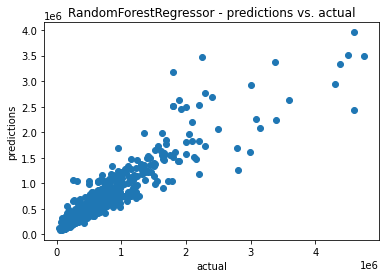

In [24]:
# fitting RandomForestRegressor model with best_params_ (see above)
model = RandomForestRegressor(
    max_depth=best_params_rfr['max_depth'], 
    n_estimators=best_params_rfr['n_estimators'],
    max_features=best_params_rfr['max_features']
    )

model.fit(X_train, y_train)

#using model to make predictions
y_pred = model.predict(X_test)

#plotting predictions against test values
plt.scatter(y_test, y_pred)

plt.title('RandomForestRegressor - predictions vs. actual')
plt.xlabel('actual')
plt.ylabel('predictions')
plt.show()

In [25]:
#scoring my model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("RFR R2 score: " + str(r2))
print("RFR RMSE: " + str(rmse))
print("RFR MAE: " + str(mae))

RFR R2 score: 0.8722464438406762
RFR RMSE: 120009.90656731806
RFR MAE: 49354.1606051501


## Shap analysis

In [26]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

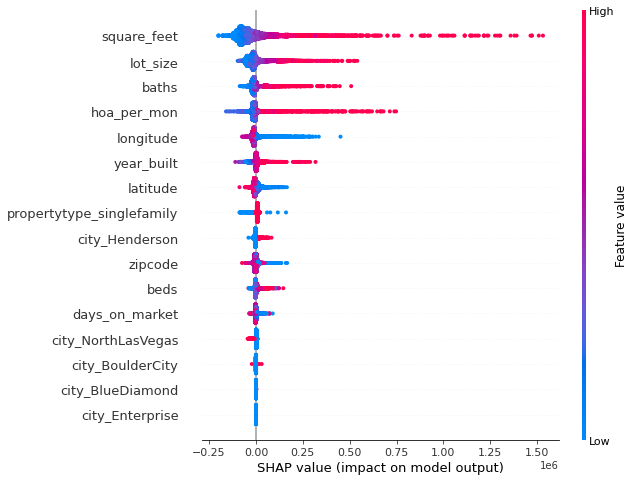

In [27]:
#summary plot
shap.summary_plot(shap_values, X_train)

In [28]:
#dependence plot for most important feature 
#shap.dependence_plot('square_feet', shap_values, X_train)

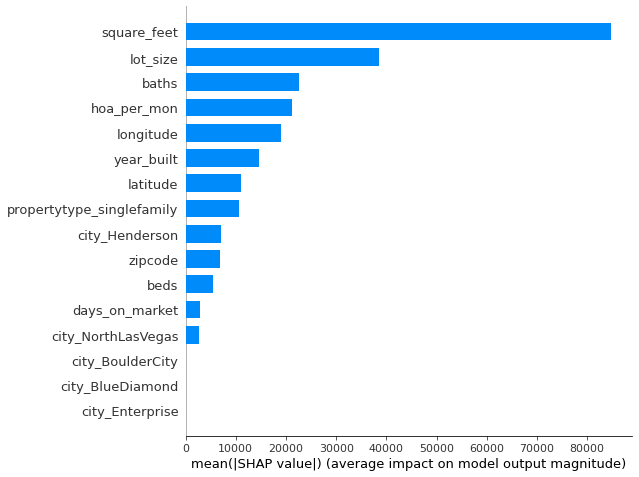

In [29]:
shap.summary_plot(shap_values, X_train, plot_type='bar')